<a href="https://colab.research.google.com/github/novelworm777/bangkit-kaidah-machine-learning/blob/main/Data_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# only run this in google colab to upload data
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving jdih_kemenkeu_regulations.csv to jdih_kemenkeu_regulations.csv
User uploaded file "jdih_kemenkeu_regulations.csv" with length 1537224 bytes


In [2]:
# only run this in google colab to install sastrawi library
!pip install Sastrawi

     |████████████████████████████████| 215kB 6.5MB/s 


In [25]:
# import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import os
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.stem.snowball import SnowballStemmer

# Load Data

In [4]:
# load raw data
path = 'jdih_kemenkeu_regulations.csv'
raw_data_df = pd.read_csv(path)

# let's check inside the dataframe
print(raw_data_df.info())
raw_data_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9176 entries, 0 to 9175
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   9170 non-null   object
 1   label   9176 non-null   object
dtypes: object(2)
memory usage: 143.5+ KB
None


,title,label
0,Jenis dan Tarif atas Jenis Penerimaan Negara B...,"Jenis Dan Tarif, Penerimaan Negara Bukan Pajak..."
1,"Tata Cara Pendaftaran, Pelaporan, dan Pendataa...","Pajak Bumi Dan Bangunan, Pendaftaran Dan Pelap..."
2,Pedoman Standar Pelayanan di Lingkungan Kement...,"Pedoman, Standar Pelayanan, Kementerian Keuangan"
3,Account Representative pada Kantor Pelayanan P...,"Account Representative, Kantor Pelayanan Pajak"
4,Perubahan Kedua atas Peraturan Menteri Keuanga...,"Perubahan Kedua, Program Pen, Pemerintah Daerah"


# Data Preprocessing

## Data Cleaning - Part 1

In [5]:
# there are some rows that have no title
# let's drop the null rows
dropped_df = raw_data_df.dropna().reset_index(drop=True)
dropped_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9170 entries, 0 to 9169
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   9170 non-null   object
 1   label   9170 non-null   object
dtypes: object(2)
memory usage: 143.4+ KB


## Data Wrangling

In [6]:
# the labels will need to be changed into columns
# count the number of labels in each row
pd.options.mode.chained_assignment = None # warning disable
dropped_df['label_count'] = dropped_df['label'].apply(lambda x: len(str(x).split(', ')))
print("Labels distribution per doc:\n", dropped_df.label_count.value_counts(sort=False))

Labels distribution per doc:
 1     371
2    1783
3    6745
4     235
5      32
6       4
Name: label_count, dtype: int64


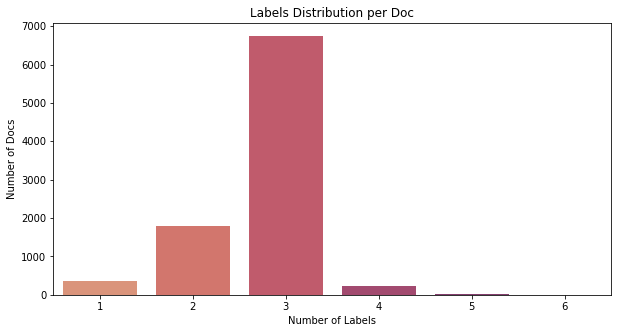

In [7]:
# visualize the labels distribution
plt.figure(figsize=(10, 5))
sns.countplot(x=dropped_df.label_count, palette='flare')
plt.title("Labels Distribution per Doc")
plt.xlabel("Number of Labels")
plt.ylabel("Number of Docs")
plt.show()

In [8]:
# let's get the unique labels
# split the labels of each row into separate columns
max_value = dropped_df['label_count'].max()
columns = ['label_' + str(x) for x in range(1, max_value+1)]
label_df = pd.DataFrame(dropped_df['label'].apply(lambda x: str(x).split(', ')).to_list(), columns=columns)
label_df.head()

,label_1,label_2,label_3,label_4,label_5,label_6
0,Jenis Dan Tarif,Penerimaan Negara Bukan Pajak,Kementerian Hukum Dan Ham,None,None,None
1,Pajak Bumi Dan Bangunan,Pendaftaran Dan Pelaporan,Objek Pajak Bumi,None,None,None
2,Pedoman,Standar Pelayanan,Kementerian Keuangan,None,None,None
3,Account Representative,Kantor Pelayanan Pajak,None,None,None,None
4,Perubahan Kedua,Program Pen,Pemerintah Daerah,None,None,None


In [9]:
# combine all columns into one and only leave the unique labels
combined_label_df = label_df.stack().reset_index()[[0]]
labels = combined_label_df[0].unique()
print("Number of unique labels:", len(labels))

Number of unique labels: 4632


In [10]:
# make the unique labels into new columns and replace all missing values into 0
new_label_df = pd.concat([label_df, pd.DataFrame(columns=list(labels))])
new_label_df.fillna(0, inplace=True)
new_label_df.head()

,label_1,label_2,label_3,label_4,label_5,label_6,Jenis Dan Tarif,Penerimaan Negara Bukan Pajak,Kementerian Hukum Dan Ham,Pajak Bumi Dan Bangunan,Pendaftaran Dan Pelaporan,Objek Pajak Bumi,Pedoman,Standar Pelayanan,Kementerian Keuangan,Account Representative,Kantor Pelayanan Pajak,Perubahan Kedua,Program Pen,Pemerintah Daerah,Tunjangan Hari Raya,Gaji Ketiga Belas,Tahun Anggaran 2021,Petunjuk Teknis,Dana Desa,Dana Perimbangan,Pemotongan,Perubahan,Tagihan Listrik,Biaya Operasional,Pembayaran Manfaat Pensiun,Pt Taspen,Pajak Pertambahan Nilai,Air Bersih,Pelabuhan Bebas,Kawasan Perdagangan Bebas,Pemasukan/Pengeluaran Barang,Kawasan Ekonomi,Khusus,Badan Usaha Penjaminan,...,Pembentukan Daerah Tingkat I,Perubahan Perpu,Belastingzaken,Tentara Angkatan Darat,Tenaga Asing,Wilayah Republik Indonesia,Hukum Pidana,Penjualan Rumah-Rumah Negeri,Tidak Ada Atau Berhalangan,Pengganti,Hubungan Internasional,Pemakaian Gelar Akuntan,Penguasaan,Barang Bukti,Barang Yang Dirampas,Uud 1945,Belasting,Zaken,Perburuhan,Serikat Buruh Dan Majikan,Pengajaran Di Sekolah,Dasar-Dasar Pendidikan,Pernyataan Berlakunya,Militer Wajib,Uang Saku,Kedudukan Hukum Militer Sukarela,Bekas Anggota Komite Nasional,Dewan Kehormatan Militer,Jabatan Dalam Dinas,Pangkat Militer Khusus,Pegawai Yang Tewas,Pemberian Uang Duka,Janda/Ahli Waris,Wajib Militer,Perpanjangan Dinas,Kepangkatan Militer/Polisi,Hak Kepegawaian,Besarnya Iuran,Tata Cara Penjualan,Syarat-Syarat
0,Jenis Dan Tarif,Penerimaan Negara Bukan Pajak,Kementerian Hukum Dan Ham,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Pajak Bumi Dan Bangunan,Pendaftaran Dan Pelaporan,Objek Pajak Bumi,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Pedoman,Standar Pelayanan,Kementerian Keuangan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Account Representative,Kantor Pelayanan Pajak,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Perubahan Kedua,Program Pen,Pemerintah Daerah,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [11]:
# fill the label columns with 1 if the label exist for that row
for column in columns:
    for index, label in enumerate(new_label_df[column]):
        if label != 0:
            new_label_df.loc[index, label] = 1
new_label_df.head()

,label_1,label_2,label_3,label_4,label_5,label_6,Jenis Dan Tarif,Penerimaan Negara Bukan Pajak,Kementerian Hukum Dan Ham,Pajak Bumi Dan Bangunan,Pendaftaran Dan Pelaporan,Objek Pajak Bumi,Pedoman,Standar Pelayanan,Kementerian Keuangan,Account Representative,Kantor Pelayanan Pajak,Perubahan Kedua,Program Pen,Pemerintah Daerah,Tunjangan Hari Raya,Gaji Ketiga Belas,Tahun Anggaran 2021,Petunjuk Teknis,Dana Desa,Dana Perimbangan,Pemotongan,Perubahan,Tagihan Listrik,Biaya Operasional,Pembayaran Manfaat Pensiun,Pt Taspen,Pajak Pertambahan Nilai,Air Bersih,Pelabuhan Bebas,Kawasan Perdagangan Bebas,Pemasukan/Pengeluaran Barang,Kawasan Ekonomi,Khusus,Badan Usaha Penjaminan,...,Pembentukan Daerah Tingkat I,Perubahan Perpu,Belastingzaken,Tentara Angkatan Darat,Tenaga Asing,Wilayah Republik Indonesia,Hukum Pidana,Penjualan Rumah-Rumah Negeri,Tidak Ada Atau Berhalangan,Pengganti,Hubungan Internasional,Pemakaian Gelar Akuntan,Penguasaan,Barang Bukti,Barang Yang Dirampas,Uud 1945,Belasting,Zaken,Perburuhan,Serikat Buruh Dan Majikan,Pengajaran Di Sekolah,Dasar-Dasar Pendidikan,Pernyataan Berlakunya,Militer Wajib,Uang Saku,Kedudukan Hukum Militer Sukarela,Bekas Anggota Komite Nasional,Dewan Kehormatan Militer,Jabatan Dalam Dinas,Pangkat Militer Khusus,Pegawai Yang Tewas,Pemberian Uang Duka,Janda/Ahli Waris,Wajib Militer,Perpanjangan Dinas,Kepangkatan Militer/Polisi,Hak Kepegawaian,Besarnya Iuran,Tata Cara Penjualan,Syarat-Syarat
0,Jenis Dan Tarif,Penerimaan Negara Bukan Pajak,Kementerian Hukum Dan Ham,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Pajak Bumi Dan Bangunan,Pendaftaran Dan Pelaporan,Objek Pajak Bumi,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Pedoman,Standar Pelayanan,Kementerian Keuangan,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Account Representative,Kantor Pelayanan Pajak,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Perubahan Kedua,Program Pen,Pemerintah Daerah,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [12]:
# combine the label columns as labels of the dataset
dataset_df = pd.concat([dropped_df['title'], new_label_df.loc[:, labels[0]:]], axis=1)
dataset_df[labels] = dataset_df[labels].apply(lambda x: x.astype('int'))
dataset_df.head()

,title,Jenis Dan Tarif,Penerimaan Negara Bukan Pajak,Kementerian Hukum Dan Ham,Pajak Bumi Dan Bangunan,Pendaftaran Dan Pelaporan,Objek Pajak Bumi,Pedoman,Standar Pelayanan,Kementerian Keuangan,Account Representative,Kantor Pelayanan Pajak,Perubahan Kedua,Program Pen,Pemerintah Daerah,Tunjangan Hari Raya,Gaji Ketiga Belas,Tahun Anggaran 2021,Petunjuk Teknis,Dana Desa,Dana Perimbangan,Pemotongan,Perubahan,Tagihan Listrik,Biaya Operasional,Pembayaran Manfaat Pensiun,Pt Taspen,Pajak Pertambahan Nilai,Air Bersih,Pelabuhan Bebas,Kawasan Perdagangan Bebas,Pemasukan/Pengeluaran Barang,Kawasan Ekonomi,Khusus,Badan Usaha Penjaminan,Pajak Penjualan Atas Barang Mewah,Kendaraan Bermotor,Ditanggung Pemerintah,Pemberian Jaminan Pemerintah,Proyek Strategis Nasional,...,Pembentukan Daerah Tingkat I,Perubahan Perpu,Belastingzaken,Tentara Angkatan Darat,Tenaga Asing,Wilayah Republik Indonesia,Hukum Pidana,Penjualan Rumah-Rumah Negeri,Tidak Ada Atau Berhalangan,Pengganti,Hubungan Internasional,Pemakaian Gelar Akuntan,Penguasaan,Barang Bukti,Barang Yang Dirampas,Uud 1945,Belasting,Zaken,Perburuhan,Serikat Buruh Dan Majikan,Pengajaran Di Sekolah,Dasar-Dasar Pendidikan,Pernyataan Berlakunya,Militer Wajib,Uang Saku,Kedudukan Hukum Militer Sukarela,Bekas Anggota Komite Nasional,Dewan Kehormatan Militer,Jabatan Dalam Dinas,Pangkat Militer Khusus,Pegawai Yang Tewas,Pemberian Uang Duka,Janda/Ahli Waris,Wajib Militer,Perpanjangan Dinas,Kepangkatan Militer/Polisi,Hak Kepegawaian,Besarnya Iuran,Tata Cara Penjualan,Syarat-Syarat
0,Jenis dan Tarif atas Jenis Penerimaan Negara B...,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"Tata Cara Pendaftaran, Pelaporan, dan Pendataa...",0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Pedoman Standar Pelayanan di Lingkungan Kement...,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Account Representative pada Kantor Pelayanan P...,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Perubahan Kedua atas Peraturan Menteri Keuanga...,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Data Cleaning - Part 2

### Labels

In [13]:
# count the number of each label appear
label_count = pd.DataFrame()
label_count['label'] = dataset_df.columns[1:]
label_count['count'] = dataset_df.iloc[:, 1:].sum().values
label_count.sort_values(['count'], inplace=True, ascending=False)
label_count.reset_index(inplace=True, drop=True)
label_count.describe()

,count
count,4632.000000
mean,5.459197
std,20.994525
min,1.000000
25%,1.000000
50%,2.000000
75%,4.000000
max,792.000000


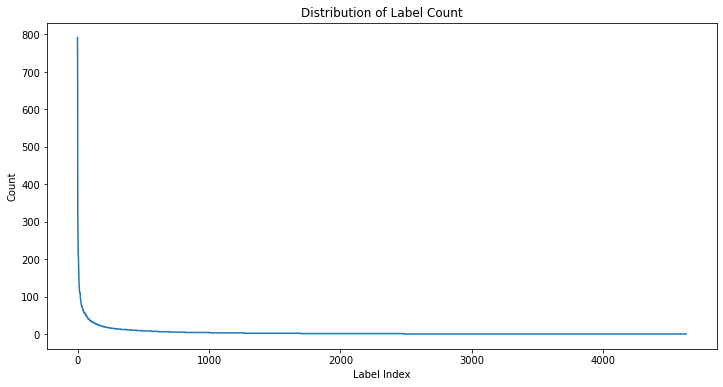

In [14]:
# visualize the distribution of label count
plt.figure(figsize=(12, 6))
plt.plot(label_count['count'].values)
plt.title("Distribution of Label Count")
plt.xlabel("Label Index")
plt.ylabel("Count")
plt.show()

In [15]:
# some labels don't have enough data points
# which can make prediction less precise
# let's cut the number of labels down with threshold
main_label_df = pd.DataFrame()
main_label_df = label_count[label_count['count']>50]
main_labels = main_label_df['label'].values
print("Number of labels above threshold:", len(main_labels))

# the labels below threshold will be clustered to a new label
new_label = 'Lain'
main_labels = np.append(main_labels, new_label)

Number of labels above threshold: 66


In [16]:
# move the labels below threshold count to the new label
cut_dataset_df = dataset_df.copy()
cut_dataset_df[new_label] = 0
not_label = []
for column in cut_dataset_df.columns[1:]:
    if column not in main_labels:
        cut_dataset_df[new_label][cut_dataset_df[column]==1] = 1
        not_label.append(column)

# drop the columns of labels below threshold
cut_dataset_df.drop(not_label, axis=1, inplace=True)
cut_dataset_df.shape

(9170, 68)

In [17]:
# recount the number of each label appear
cut_label_count = pd.DataFrame()
cut_label_count['label'] = cut_dataset_df.columns[1:]
cut_label_count['count'] = cut_dataset_df.iloc[:, 1:].sum().values
cut_label_count.sort_values(['count'], inplace=True, ascending=False)
cut_label_count.reset_index(inplace=True, drop=True)
cut_label_count.describe()

,count
count,67.000000
mean,245.865672
std,1053.936041
min,51.000000
25%,59.000000
50%,77.000000
75%,114.500000
max,8684.000000


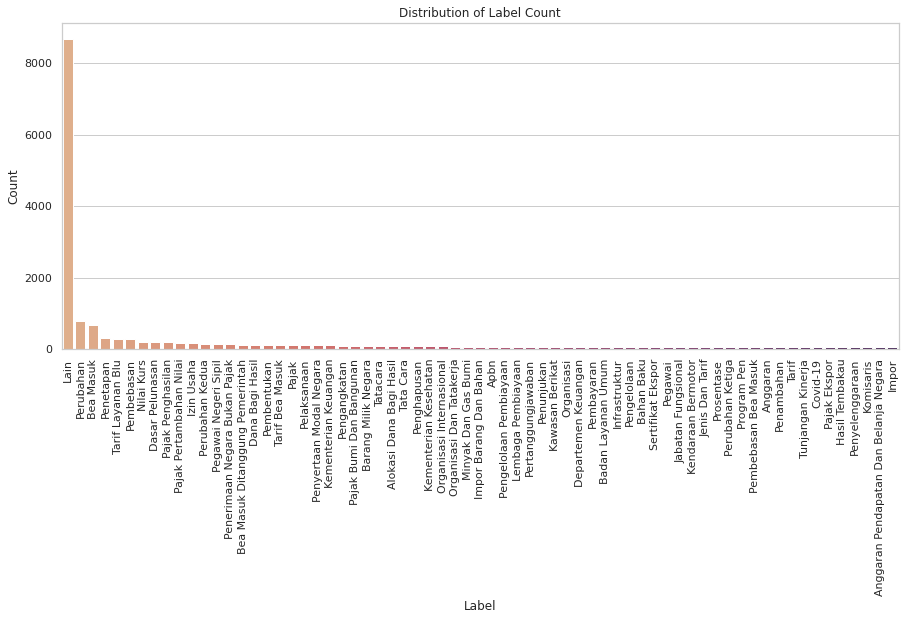

In [18]:
# visualize the distribution of label count
plt.figure(figsize=(15, 6))
sns.set(font_scale = 1)
sns.set_style('whitegrid') 
pal = sns.color_palette('flare', len(cut_label_count))
rank = cut_label_count['count'].argsort().argsort()  
sns.barplot(x=cut_label_count['label'], y=cut_label_count['count'], palette=np.array(pal[::-1])[rank])
plt.title("Distribution of Label Count")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks(rotation='vertical')
plt.show()

### Text

In [19]:
# check rows duplicated by title
duplicated_title_df = cut_dataset_df[cut_dataset_df.duplicated(['title'])]
duplicated_title_df.sort_values(['title'], inplace=True)
print("Number of rows with duplicated title:", duplicated_title_df.shape[0])

# check rows duplicated by title and labels
duplicated_title_label_df = cut_dataset_df[cut_dataset_df.duplicated(cut_dataset_df.columns)]
print("Number of rows with duplicated title and having the same labels", duplicated_title_label_df.shape[0])

Number of rows with duplicated title: 554
Number of rows with duplicated title and having the same labels 461


In [20]:
# there are difference between the two numbers
# which means, there are rows with duplicated title, but different labels
# let's keep the rows prioritizing the ones without the new label
drop_duplicated_df = cut_dataset_df.sort_values(['title', new_label], ascending=[True, True])
drop_duplicated_df.drop_duplicates(inplace=True)
drop_duplicated_df.shape

(8709, 68)

In [21]:
# initialize for stop words and stemming
stopword = StopWordRemoverFactory().create_stop_word_remover()
stemmer_indo = StemmerFactory().create_stemmer()
stemmer_eng = SnowballStemmer("english")

# function to keep only words containing letters A-Z and a-z
# remove all punctuations, numbers, etc
def cleanPunc(sentence):
    cleaned_sentence = ""
    for word in sentence.split():
        cleaned_word = re.sub('[^a-zA-Z]',' ', word)
        cleaned_sentence += cleaned_word.strip()
        cleaned_sentence += " "
    return cleaned_sentence.strip()

# function for removing stop words
def removeStopWords(sentence):
    return stopword.remove(sentence)

# function for stemming
def stemming(sentence):
    stemmed_indo = stemmer_indo.stem(sentence)
    stemmed_sentence = ""
    for word in stemmed_indo.split():
        stemmed_eng = stemmer_eng.stem(word)
        stemmed_sentence += stemmed_eng
        stemmed_sentence += " "
    stemmed_sentence = stemmed_sentence.strip()
    return stemmed_sentence

In [22]:
# apply text cleaning to title
cleaned_df = drop_duplicated_df.copy()
cleaned_df['title'] = cleaned_df['title'].str.lower()
cleaned_df['title'] = cleaned_df['title'].apply(cleanPunc)
cleaned_df['title'] = cleaned_df['title'].apply(removeStopWords)
cleaned_df['title'] = cleaned_df['title'].apply(stemming)

In [23]:
# let's tidy up the dataset for the last time
cleaned_df.rename(columns={'title': 'Title'}, inplace=True)
cleaned_df.head()

,Title,Jenis Dan Tarif,Penerimaan Negara Bukan Pajak,Pajak Bumi Dan Bangunan,Kementerian Keuangan,Perubahan Kedua,Program Pen,Perubahan,Pajak Pertambahan Nilai,Kendaraan Bermotor,Tarif Layanan Blu,Kementerian Kesehatan,Anggaran Pendapatan Dan Belanja Negara,Dana Bagi Hasil,Organisasi Dan Tatakerja,Covid-19,Penyelenggaraan,Bea Masuk,Pajak Penghasilan,Jabatan Fungsional,Organisasi Internasional,Pegawai Negeri Sipil,Pengelolaan,Anggaran,Tata Cara,Pembayaran,Pertanggungjawaban,Pegawai,Infrastruktur,Lembaga Pembiayaan,Perubahan Ketiga,Barang Milik Negara,Tarif Bea Masuk,Apbn,Penyertaan Modal Negara,Tarif,Badan Layanan Umum,Impor,Minyak Dan Gas Bumi,Bea Masuk Ditanggung Pemerintah,Penghapusan,Pengelolaan Pembiayaan,Kawasan Berikat,Penetapan,Hasil Tembakau,Pelaksanaan,Pembebasan Bea Masuk,Organisasi,Pembentukan,Penambahan,Pajak,Pembebasan,Tunjangan Kinerja,Tatacara,Izin Usaha,Impor Barang Dan Bahan,Pengangkatan,Penunjukan,Alokasi Dana Bagi Hasil,Departemen Keuangan,Bahan Baku,Dasar Pelunasan,Nilai Kurs,Komisaris,Pajak Ekspor,Sertifikat Ekspor,Prosentase,Lain
9030,acara tetap ganti rugi adil tinggi hubung cabu...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,account repres kantor layan pajak,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1747,account repres kantor layan pajak,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1970,administrasi perintah,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1097,administrasi kelola hibah,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


# Save and Download Data

In [33]:
# save the preprocessed data
directory = './data/'
if not os.path.exists(directory):
    os.mkdir(directory)
saved_data_path = os.path.join(directory, 'dataset.csv')
cleaned_df.to_csv(saved_data_path, index=False)

In [35]:
# only run this in google colab to download data
from google.colab import files

files.download(saved_data_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>